# DRx class details

**Class DRx(dimensionality_reduction_model, feature_names, initial_data)**

**Parameters:**



*   **dimensionality_reduction_model:** model used to dimensionally reduce the data (should be fitted on the initial dataset prior the object creation).
*   **feature_names:** The names of the dataset columns.
*   **initial_data:** 2d array contaning the orgina dataset

**Methods**



*   **explain_instance(instance, number_of_neghbours, auto_alpha, use_LIME)** Provides us with the weights needed for the explanations.


*   **find_reconstruction_error(data, number_of_neighbours, auto_alpha, use_LIME,use_mean, normalised)** Prints mean absolute error, cosine error, euclidean error between the reduced data extracted through DRx and the dimensionality reduction technique.


*   **find_weights_error(data, number_of_neighbours, auto_alpha, use_LIME, normalised)** This function only works when the dimensionality reduction technique is able to return weights per each component. Prints mean absolute error, cosine error, euclidean error between the weigths created through DRx, and weights extracted through the dimensionality reduction technique.

*   **visualise_weights(instance, dimension, number_of_neighbours,auto_alpha, use_LIME, normalised)** This function only works when the dimensionality reduction technique is able to return weights per each component. Creates a plot that compares weights extracted from DRx and the dimensionality reduction technique, of a particular dimension of the instance.


*   **visualise_reconstructed(instance, number_of_neighbours, auto_alpha, use_LIME, use_mean, normalised)** Reconstructs the dimensionally reduced data throught the weights extracted from DRx, and compares them with the dimensionally reduced data given from the dimensionality reduction technique for a particular instance.

*   **create_heatmap(instance, number_of_neighbours, auto_alpha, use_LIME, normalised)** Plots a Heatmap showing the difference between weigths extracted through DRx and weigths extracted from the dimensionality reduction technique, for a particular instance.

*   **get_feature_importance(instance, number_of_neighbours, auto_alpha, use_LIME, use_mean, normalised)** Creates and prints an array shaped (N_features, N_reduced_features) where for each reduced features, highlights the original feature that contributed the most to its creation.

**Variables**

*   **number_of_neighbours**: int, the number of neighours we want to use to achieve the local interpretation. If 'auto' the number will be chosen depending on the dataset. 

*   **auto_alpha**: boolean, if True, function best_alpha will be used to find most suitable alpha for the linear model. If False, default value of alpha will be used (alpha=1.0). 

*   **use_LIME**: boolean, if True, function give_me_the_neighbourhood of LimeTabularExplainer is used for the neighbourhood extraction. If False, sklearn NearestNeighbors() will be used. 

*   **use_mean**: boolean, if True, mean value of the data will be subtracted for each instance. 

*   **normalised**: boolean, if True, data will be divided with the absolute max value of the data.






# Code Example

## Imports

In [11]:
import math
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

## Lime installation

In [2]:
!pip install lime==0.2.0.1

     |████████████████████████████████| 275 kB 4.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e68326bf96178a59da78116af8c3adef7b3cd525929c8ed4ef80150eed3217a7
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


## lime_tabular

In order to take advantage of LIME neighborhood generation, lime_tabular.py shall be moved into lime's file directory. This can be done by running the code bellow.

In [3]:
!mv lime_tabular.py /usr/local/lib/python3.7/dist-packages/lime/

## Load the dataset

For this example we will use the diabetes dataset and PCA as a dimensionality reduction technique. Since PCA is interpretable, it will give us the ability to compare the results of DRx with the ground truth.

In [4]:
#Load data
diabetes = datasets.load_diabetes()
initial_data = diabetes.data
initial_predictions = diabetes.target
feature_names = diabetes.feature_names

#train_test_split the data (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
     initial_data, initial_predictions, test_size=0.2, random_state=42)

# initialize and fit PCA
pca = PCA(n_components=8)
pca.fit(initial_data)

#reduce dimensions from 10 to 8 on both train and test sets
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

X_test_reduced[1]

array([-0.01830892, -0.00379885,  0.08204992,  0.00632399, -0.06140154,
       -0.06166935, -0.02689931, -0.01348123])

Above we can see the reduced representation of the first instance of the test set. The dimensions were reduced from 10 to 8 (components). Since PCA is interpretable, it provides us with weights that can be utilized in order to find out which of the original features contributed the most for the creation of each component.

Nevertheless, this is not always the case, since most of DR techniques do not provide such information. This is why a technique like DRx is needed in order to provide this kind of interpretations.

In the rest of this notebook we will have a look on how DRx and its methos can be applied to solve the interpretability issue.

## Introducing DRx

Lets create an object of DRx class, and give it pca as dimensionality reduction technique, as well as the dataset and the features names of the dataset (everything was defined in the previous cell)

For the cells below, we will use for simplicity the parameters (number_of_neighbours=50, auto_alpha=True, use_LIME=True, use_mean=True, normalised=True). 

These parameter values work well in most cases, although parameter tuning is suggested for potentially better results depending on the dataset.



In [5]:
from DRx import DRx
DRx_obj = DRx(pca, feature_names, initial_data)

## Feature Importance

In the table below, DRx provides us with the amount of influence each feature had for the generation of the reduced space data. Each column represents one of the 8 components and each row represents one of the 10 features. Each highlighted cell tells us which feature contributed the most. 

For example the highlighted cell (0,0) tells us that the first feature was the one that contributed the most on the fisrt component.

In [6]:
DRx_obj.get_feature_importance(X_test[1], number_of_neighbours=50, auto_alpha=True, use_LIME=True, use_mean=True, normalised=True)

,0,1,2,3,4,5,6,7
0,0.047022,0.006596,0.090016,0.056078,0.092564,0.026289,0.016153,0.003237
1,0.019707,0.029748,0.010152,0.044642,0.023776,0.002101,0.003771,0.041883
2,0.026337,0.009934,0.012038,0.027281,0.006617,0.019009,0.029662,0.030153
3,0.013997,0.005076,0.021872,0.000496,0.015425,0.007677,0.011099,0.021872
4,0.020063,0.024960,0.003097,0.002618,0.004940,0.000304,0.002619,0.006898
5,0.013656,0.013148,0.008620,0.004129,0.003002,0.002711,0.006144,0.006782
6,0.000520,0.000696,0.000580,0.000085,0.000273,0.000100,0.000006,0.000528
7,0.039493,0.005040,0.029420,0.000550,0.008331,0.001545,0.004591,0.015077
8,0.020057,0.001386,0.003178,0.008559,0.004700,0.005280,0.022512,0.021363
9,0.016524,0.002872,0.011241,0.002950,0.000581,0.021788,0.011675,0.007625


But how can we be sure that these results are accurate?

On the rest of the notebook we will provide comparisons between DRx and PCA.

## Weight Comparison

First, lets compare the weights created by DRx to the weights that PCA provides us.

In [7]:
print("Weights of DRx")
display(pd.DataFrame(DRx_obj.explain_instance(X_test[1], number_of_neighbours=50, auto_alpha=True, use_LIME=True)))

print("")
print("Weights of PCA")
display(pd.DataFrame(pca.components_))

Weights of DRx


,0,1,2,3,4,5,6,7,8,9
0,0.208658,0.189769,0.294365,0.264383,0.328668,0.347495,-0.271399,0.418829,0.371416,0.312952
1,0.046622,-0.373508,-0.149805,-0.132471,0.554056,0.437735,0.479452,-0.071773,-0.028116,-0.087998
2,0.482005,-0.106694,0.164212,0.503430,-0.065469,-0.264121,0.373778,-0.371317,0.058548,0.263577
3,-0.407401,-0.664111,0.483343,-0.015680,-0.073799,-0.161988,-0.071136,0.005357,0.260373,0.082545
4,-0.672417,0.362826,0.126047,0.480505,0.127938,0.114265,0.230274,-0.143724,-0.145330,0.033214
5,-0.222596,0.045108,-0.388101,-0.267688,0.000988,-0.129476,0.097728,-0.029334,0.172104,0.779382
6,-0.110115,-0.066529,-0.503203,0.314636,0.072642,-0.227125,-0.005156,0.068993,0.637544,-0.352202
7,0.016906,0.430456,0.376658,-0.464068,0.126683,-0.183804,0.307330,-0.176127,0.441741,-0.161828



Weights of PCA


,0,1,2,3,4,5,6,7,8,9
0,0.216431,0.186967,0.303162,0.271740,0.343255,0.351861,-0.282436,0.428833,0.378617,0.322183
1,0.044372,-0.386548,-0.156281,-0.138256,0.573027,0.455940,0.506243,-0.068184,-0.026189,-0.084947
2,0.494668,-0.106858,0.167532,0.513568,-0.068587,-0.269694,0.386028,-0.380681,0.063632,0.276843
3,-0.414009,-0.679861,0.499825,-0.019667,-0.068395,-0.167774,-0.076020,0.007921,0.264427,0.087086
4,-0.686864,0.373456,0.129359,0.486890,0.129174,0.116731,0.244991,-0.143644,-0.151661,0.031388
5,-0.225851,0.041731,-0.403142,-0.272763,0.005409,-0.133257,0.106372,-0.033945,0.178730,0.805064
6,-0.109538,-0.067606,-0.519858,0.320649,0.073649,-0.230540,-0.007534,0.071236,0.647313,-0.357273
7,0.014935,0.442940,0.392942,-0.477364,0.129414,-0.191311,0.324636,-0.180588,0.449660,-0.166609


As we can see above, DRx was able to generate very similar weights. It is worthy mentioning that DRx creates a set of weights for each individual instance, while PCA has only one set of weights for the entire dataset.

A more intuitive comparison of the weights for the same instance can be seen in the heatmap below.


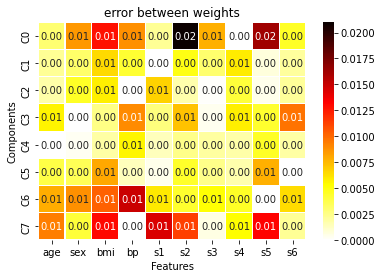

In [8]:
DRx_obj.create_heatmap(X_test[1], number_of_neighbours=50, auto_alpha=True, use_LIME=True, normalised=True)

Lets also calculate the error between the weights of DRx and PCA for the whole dataset. Below we can see the Mean Absolute Error, the Cosine Error and the Euclidean error.

In [9]:
print(DRx_obj.find_weights_error(X_test, number_of_neighbours=50, auto_alpha=True, use_LIME=True, normalised=True))

mean_absolute_error =  0.005656234366741156
cosine error =  8.104713621123828e-05
euclidean error =  0.02293679029154292
(0.005656234366741156, 8.104713621123828e-05, 0.02293679029154292)


## Instance difference

Below we can see the comparison between the reduced space instance generated via the weights of DRx and the weights of DRt (PCA).

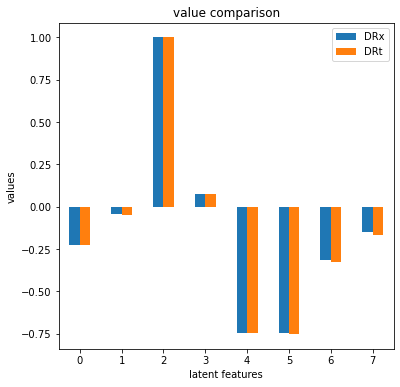

mean_absolute_error =  0.0009949102205181895
cosine error =  5.2601696438725476e-05
euclidean error =  0.01659969392203831


(0.0009949102205181895, array([[5.26016964e-05]]), array([[0.01659969]]))

In [10]:
DRx_obj.visualise_reconstructed(X_test[1], number_of_neighbours=50, auto_alpha=True, use_LIME=True, use_mean=True, normalised=True)

DRx_obj.find_reconstruction_error(X_test[1].reshape(1, -1), number_of_neighbours=50, auto_alpha=True, use_LIME=True, use_mean=True, normalised=True)